In this project, I use pytorch to create a neural network that predicts whether a tumor is benign or malignant based on 17 visual characteristics. This is a binary classification problem and the dataset is obtained from Kaggle at the following link:  https://www.kaggle.com/datasets/erdemtaha/cancer-data. 

In [215]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [216]:
# read data
df = pd.read_csv('Cancer_Data.csv')
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [217]:
# check for missing values
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [218]:
# count the number of benign and malignant diagnoses
total_m = 0
for diagnosis in df['diagnosis']:
    if diagnosis == 'M':
        total_m += 1

total_b = len(df['diagnosis']) - total_m
diagnosis_percent = (total_b/(total_m + total_b))*100
print(f'Number of malignant diagnosis: {total_m}, number of benign diagnosis: {total_b}, percentage benign: {diagnosis_percent:.2f} %.')

Number of malignant diagnosis: 212, number of benign diagnosis: 357, percentage benign: 62.74 %.


Since ~63% of the diagnoses are benign, it is important to stratify the training and testing splits.

In [219]:
# split into X and y sections
X = df.iloc[:, 2:19].values
y = df.iloc[:, [1]].values 

In [220]:
# encode binary classes 'B' and 'M'into integers
encoder = LabelEncoder()
encoder.fit(y.ravel())
y = encoder.transform(y.ravel())
print(encoder.classes_)

['B' 'M']


In [221]:
# stratified k-fold cross validator
skf = StratifiedKFold(n_splits=3, shuffle=True)

In [222]:
# create model class
class CancerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CancerModel, self).__init__()

        # define layers
        self.layer_1 = nn.Linear(input_size, hidden_size)
        self.relu_1 = nn.ReLU()

        self.layer_2 = nn.Linear(hidden_size, hidden_size)
        self.relu_2 = nn.ReLU()

        self.layer_3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    # define forward pass
    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)

        x = self.layer_2(x)
        x = self.relu_2(x)

        x = self.layer_3(x)
        yhat = self.sigmoid(x)
        

        return yhat

In [223]:
# wrap training loop in a function

def train(X_train, y_train, model):
    
    epochs = 100
    total_loss = []


    for epoch in tqdm(range(epochs), desc='Epochs'):

        Yhat = model(X_train_tensor)
        Yhat = torch.reshape(Yhat, (-1,))

        loss_batch = criterion(Yhat, y_train_tensor)
        total_loss.append(loss_batch.item())

        # inner loop consists of forward pass and backpropagation
        for x, j in zip(X_train_tensor, y_train_tensor):

            yhat = model(x)
            yhat = torch.reshape(yhat, (-1,))
            j = torch.reshape(j, (-1,))
            
            loss = criterion(yhat, j)

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()        

    # loss function
    x_line = range(epochs)
    plt.plot(x_line, total_loss)
    plt.title("Loss function")
    plt.xlabel('Training iterations')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


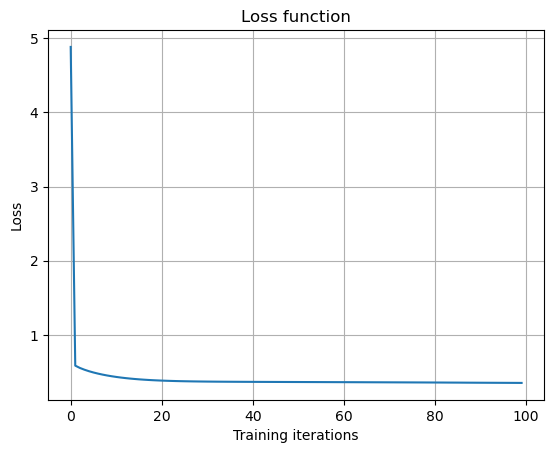

The model accuracy on fold 0 is 86.842 %.


Epochs: 100%|██████████| 100/100 [00:19<00:00,  5.21it/s]


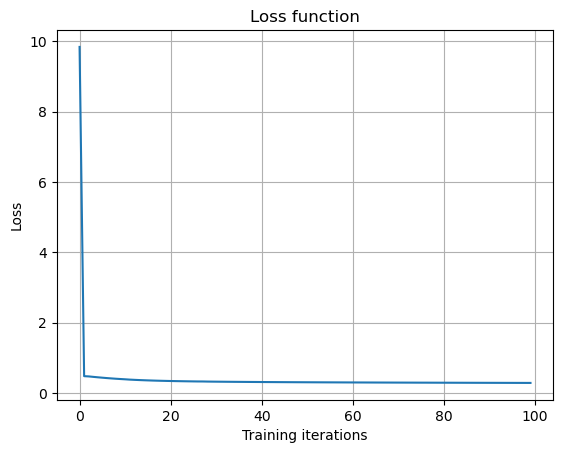

The model accuracy on fold 1 is 85.789 %.


Epochs: 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


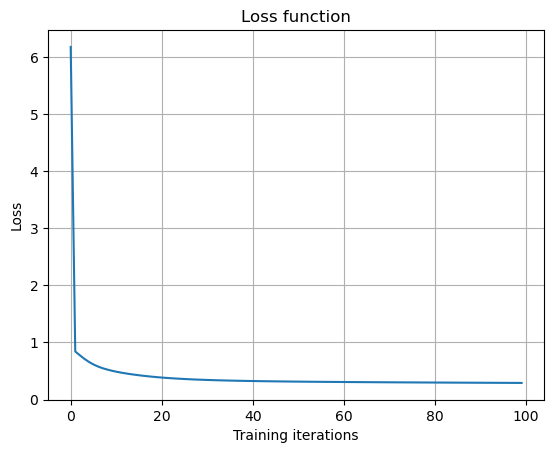

The model accuracy on fold 2 is 89.947 %.


In [224]:
# call training function on the model
for i, (train_index, test_index) in enumerate(skf.split(X, y)):

    
    # define train/test splits
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    # create tensors
    X_train_tensor = torch.as_tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.as_tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.as_tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.as_tensor(y_test, dtype=torch.float32)
    

    # define model parameters
    n_samples, n_features = X_train_tensor.shape
    input_size = n_features
    hidden_size = 12
    output_size = 1

    # define model
    model = CancerModel(input_size, hidden_size, output_size)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

    # train model
    train(X_train_tensor, y_train_tensor, model)

    # make predictions
    prediction = model(X_test_tensor).detach().numpy()
    prediction = prediction.round() # round to either 0 or 1
    prediction = prediction.squeeze(1)

    # evaluate predictions
    n_correct = 0.0

    for l, m in zip(prediction, y_test_tensor):

        if l == m:
            n_correct += 1

    accuracy = (n_correct/len(y_test))*100
    print(f'The model accuracy on fold {i} is {accuracy:.3f} %.')

    

In [225]:
# save model
# torch.save(model.state_dict(), './cancer_classifier_model.pth')

In [226]:
# check accuracy against guesses of all zeros
baseline_correct = 0.0
zeros = np.zeros_like(y_test)
y_test = np.asarray(y_test)
for x, y in zip(zeros, y_test):

    if x==y:
        baseline_correct += 1

baseline_acc = (baseline_correct/len(y_test))*100
print(f'Baseline accuracy is {baseline_acc} %')

Baseline accuracy is 62.96296296296296 %


In [227]:
600000*40000

24000000000